In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
soybean_large = fetch_ucirepo(id=90) 
  
# data (as pandas dataframes) 
X = soybean_large.data.features 
y = soybean_large.data.targets 

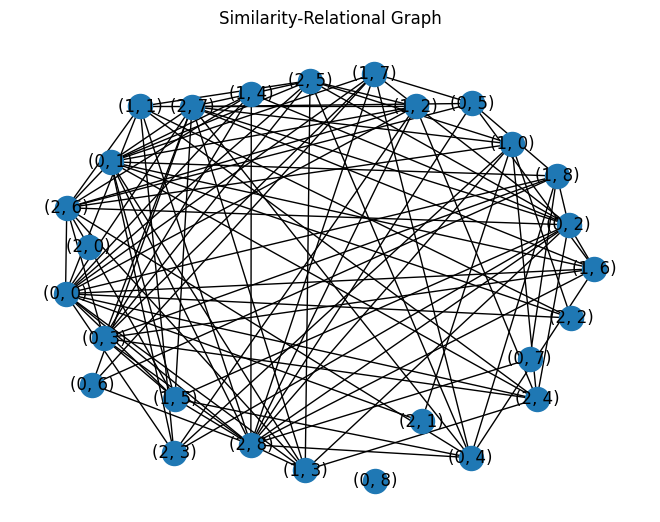

c:\Users\Predator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:646: UserWarning: Nearest neighbors affinity currently does not support sparse input, falling back to rbf affinity
  warnings.warn(


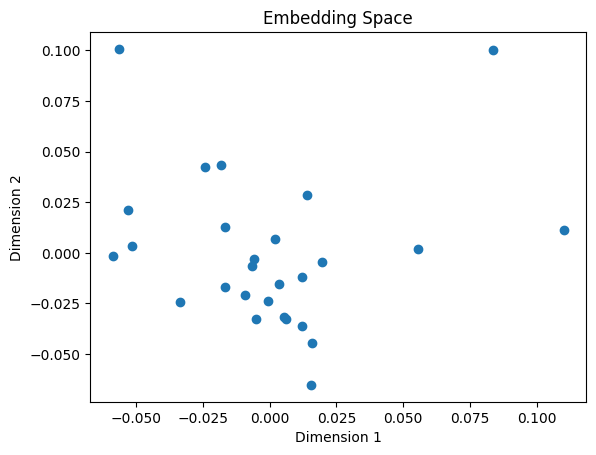

Embedding Matrix:
 [[ 0.00200589  0.00678157]
 [ 0.01217844 -0.03598214]
 [ 0.00627108 -0.03261099]
 [ 0.00368061 -0.01539747]
 [ 0.01540703 -0.06524907]
 [-0.05277233  0.02092165]
 [-0.00670043 -0.00674191]
 [ 0.01585131 -0.04435218]
 [ 0.05558993  0.00171484]
 [-0.05616291  0.10070543]
 [ 0.01389053  0.02850292]
 [-0.00935715 -0.02104709]
 [-0.03334584 -0.02419605]
 [-0.01674948 -0.016654  ]
 [-0.05859983 -0.00155807]
 [ 0.01226597 -0.01198696]
 [ 0.01962169 -0.00457949]
 [-0.01683304  0.01299475]
 [-0.00570846 -0.0032551 ]
 [ 0.00528941 -0.03183655]
 [-0.05152332  0.00325745]
 [-0.00519473 -0.03279491]
 [ 0.11002496  0.01139649]
 [ 0.08372996  0.10013858]
 [-0.00064349 -0.02389867]
 [-0.02408349  0.04249019]
 [-0.01813233  0.04323676]]


In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
import matplotlib.pyplot as plt

def construct_similarity_graph(X):
    """
    Construct a similarity-relational graph for categorical values in X.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
         Input data matrix with categorical values.
         
    Returns:
    - G: NetworkX graph
         Similarity-relational graph.
    """
    # Initialize an empty graph
    G = nx.Graph()
    
    # Perform one-hot encoding to convert categorical values to numerical
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X).toarray()
    
    # Compute pairwise cosine similarity between categorical values
    similarity_matrix = cosine_similarity(X_encoded)
    
    # Add nodes to the graph
    n_samples, n_features = X_encoded.shape
    for i in range(n_samples):
        for j in range(n_features):
            G.add_node((i, j))
    
    # Add edges to the graph based on cosine similarity
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            for k in range(n_features):
                for l in range(k+1, n_features):
                    sim = similarity_matrix[i, j]
                    G.add_edge((i, k), (j, l), weight=sim)
    
    return G

def graph_embedding(X, embedding_dim=2):
    """
    Perform graph embedding to learn the representation of nodes in the similarity-relational graph.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
         Input data matrix with categorical values.
    - embedding_dim: int, default=2
                     Dimensionality of the embedding space.
                     
    Returns:
    - embedding_matrix: array-like, shape (n_samples * n_features, embedding_dim)
                        Embedding matrix representing the nodes in the graph.
    """
    # Construct similarity-relational graph
    G = construct_similarity_graph(X)
    
    # Visualize the graph
    nx.draw(G, with_labels=True)
    plt.title('Similarity-Relational Graph')
    plt.show()
    
    # Perform spectral embedding to learn the representation of nodes
    spectral_embedding = SpectralEmbedding(n_components=embedding_dim)
    embedding_matrix = spectral_embedding.fit_transform(nx.adjacency_matrix(G))
    
    # Visualize the embedding space
    plt.scatter(embedding_matrix[:, 0], embedding_matrix[:, 1])
    plt.title('Embedding Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
    
    return embedding_matrix

# Example usage
# Assuming X is your categorical data matrix
X = np.array([
    ['A', 'B', 'C'],
    ['D', 'E', 'F'],
    ['G', 'H', 'I']
])

# Perform graph embedding
embedding_matrix = graph_embedding(X)
print("Embedding Matrix:\n", embedding_matrix)

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
import pandas as pd
from sklearn.impute import SimpleImputer

# Data 
X = soybean_large.data.features 
y = soybean_large.data.targets 

# One-hot encode categorical features
X_encoded = pd.get_dummies(X)

# Function to perform clustering and calculate performance indices
def evaluate_clustering(X, y_true, method='kmeans'):
    if method == 'kmeans':
        clustering = KMeans(n_clusters=len(np.unique(y_true))).fit(X)
    elif method == 'hierarchical':
        clustering = AgglomerativeClustering(n_clusters=len(np.unique(y_true))).fit(X)
    else:
        raise ValueError("Invalid clustering method. Use 'kmeans' or 'hierarchical'.")
    
    y_pred = clustering.labels_
    ari = adjusted_rand_score(y_true.values.ravel(), y_pred)
    nmi = normalized_mutual_info_score(y_true.values.ravel(), y_pred)
    fmi = fowlkes_mallows_score(y_true.values.ravel(), y_pred)

    
    return ari, nmi, fmi

# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X_encoded)

# Perform clustering and evaluate with different methods
ari_kmeans, nmi_kmeans, fmi_kmeans = evaluate_clustering(X_imputed, y, method='kmeans')
ari_hierarchical, nmi_hierarchical, fmi_hierarchical = evaluate_clustering(X_imputed, y, method='hierarchical')

# Print the results
print("KMeans:")
print("Adjusted Rand Index (ARI):", ari_kmeans)
print("Normalized Mutual Information (NMI):", nmi_kmeans)
print("Folkes-Mallows Index (FMI):", fmi_kmeans)

print("\nHierarchical Clustering:")
print("Adjusted Rand Index (ARI):", ari_hierarchical)
print("Normalized Mutual Information (NMI):", nmi_hierarchical)
print("Folkes-Mallows Index (FMI):", fmi_hierarchical)

KMeans:
Adjusted Rand Index (ARI): 0.39147610387067905
Normalized Mutual Information (NMI): 0.6909687932149665
Folkes-Mallows Index (FMI): 0.43958503839672614

Hierarchical Clustering:
Adjusted Rand Index (ARI): 0.4818572638479213
Normalized Mutual Information (NMI): 0.7714741801659014
Folkes-Mallows Index (FMI): 0.5238794514629941
